In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

### Load all necessary packages

In [2]:
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

from rpy2.robjects import numpy2ri, pandas2ri

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

import rpy2.robjects.lib.ggplot2 as gp
from rpy2.ipython.ggplot import image_png

from rpy2.rinterface_lib import openrlib

robjects.r('''

library(MetENP)

''')
;

''

In [3]:
%%appyter hide_code 

import pandas as pd
from io import StringIO


_formatter = robjects.r('''
install.packages("dplyr")
function (X) {
  return (
    format_tsv(
      as.data.frame(apply(X, c(1,2), function(x) {
        unlist(x, TRUE, TRUE)
      }))
    )
  )
}
''')
def as_df(data, index_col=None):
    return pd.read_csv(StringIO(_formatter(data)[0]), sep='\t', index_col=index_col)

```python
import pandas as pd
from io import StringIO
_formatter = robjects.r('''
install.packages("dplyr")
function (X) {
  return (
    format_tsv(
      as.data.frame(apply(X, c(1,2), function(x) {
        unlist(x, TRUE, TRUE)
      }))
    )
  )
}
''')
def as_df(data, index_col=None):
    return pd.read_csv(StringIO(_formatter(data)[0]), sep='\t', index_col=index_col)
```

In [4]:
from rpy2.robjects.packages import importr
metenp = importr('MetENP')

In [5]:
%%appyter hide_code
{% do SectionField(
    name='INPUT',
    title='Input Datasets',
    subtitle='Add your dataset here',
    img='upload_icon.png',
)%}
{% do SectionField(
    name='SIGM',
    title='Find Significant Metabolites',
    subtitle='Run significance of all the analysis summary together',
    img='vol.png',
)%}
{% do SectionField(
    name='COUNTCLASS',
    title='Count Metabolites by Class',
    subtitle='Count the metabolites of each class',
    img='bar.png',
)%}
{% do SectionField(
    name='ENRICH',
    title='Enrichment Score by Class',
    subtitle='Calculate the enrichment score of each metabolite class',
    img='enrich.png',
)%}
{% do SectionField(
    name='HEAT',
    title='Heatmap',
    subtitle='Heatmap of metabolites x enriched pathways',
    img='heat.png',
)%}
{% do SectionField(
    name='DOT',
    title='Dotplot',
    subtitle='Plot a dotplot of enrichment by class',
    img='dot.png',
)%}


In [6]:
%%appyter hide_code

{% set study_id = StringField(name='study_id', label='DatasetID', description = "Type your datasetID here", default='ST000915', section='INPUT') %}

In [7]:
%%appyter hide_code 

{% set studyOrg = StringField(name='studyOrg', label='KEGG Organism Code', description = "hsa for human, mmu for mouse, eco for E. coli. See https://www.genome.jp/kegg/catalog/org_list.html for all organisms", default='hsa', section='INPUT') %}

In [8]:
%%appyter hide_code

{% set classtype = MultiChoiceField(
    name='classtype',
    label='Choose a Metabolite Class',
    description='Choose between sub_class, main_class and super_class',
    default=[
        'sub_class',
    ],
    choices=[
        'sub_class',
        'main_class',
        'super_class',
    ],
    section='INPUT'
) %}

### Start data processing

### Gets metabolomics data, metadata and metabolite info from Metabolomics Workbench using REST service

In [9]:
%%appyter code_exec

data_1 = robjects.r['getmwstudies']({{
     study_id}}, 
    'data'
)

```python
data_1 = robjects.r['getmwstudies']('ST000915',
    'data'
)
```

In [10]:
%%appyter hide_code

data_1 = metenp.getmwstudies({{ study_id }}, 'data')
as_df(data_1, index_col=[0, 1, 2, 3, 4])

```python
data_1 = metenp.getmwstudies('ST000915', 'data')
as_df(data_1, index_col=[0, 1, 2, 3, 4])
```

In [11]:
with openrlib.rlock:
    
    robjects.r.assign('data_1', data_1)
    
    robjects.r('''

    data_1_print = data.frame(apply(data_1, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
    head(data_1_print)

    ''')
    
    pass

### Gets metabolomics data, metadata and metabolite info from Metabolomics Workbench using REST service

In [12]:
%%appyter code_exec

metadata = robjects.r['getmwstudies']({{
     study_id}}, 
    'factors'
)


```python
metadata = robjects.r['getmwstudies']('ST000915',
    'factors'
)
```

In [13]:
robjects.r.assign('metadata', metadata)

robjects.r('''
metadata_print = data.frame(apply(metadata, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
head(metadata_print)
''')

,,study_id,local_sample_id,subject_type,factors,Diagnosis
0,1,ST000915,NASH005,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
1,2,ST000915,NASH007,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
2,3,ST000915,NASH009,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
3,4,ST000915,NASH013,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
4,5,ST000915,NASH016,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis
5,6,ST000915,NASH022,Human clinical study,Diagnosis:Cirrhosis,Cirrhosis


### Associate metabolomics data to the refmet class

In [14]:
refmet_class = robjects.r['convert_refmet'](data_1)

robjects.r.assign('refmet_class', refmet_class)

robjects.r('''

refmet_class_print = data.frame(apply(refmet_class, c(1,2), function(x){unlist(x, TRUE, TRUE)}))
head(refmet_class_print)

''')

,,metabolite_name,analysis_id,analysis_summary,metabolite_id,...,main_class,sub_class
0,1,"1,2-DG(30:0)",AN001488,Core E Neutral Lipids,ME231190,...,Diradylglycerols,DAG
1,2,"1,2-DG(30:1)",AN001488,Core E Neutral Lipids,ME231189,...,Diradylglycerols,DAG
2,3,"1,2-DG(32:0)",AN001488,Core E Neutral Lipids,ME231196,...,Diradylglycerols,DAG
3,4,"1,2-DG(32:1)",AN001488,Core E Neutral Lipids,ME231195,...,Diradylglycerols,DAG
4,5,"1,2-DG(32:2)",AN001488,Core E Neutral Lipids,ME231194,...,Diradylglycerols,DAG
5,6,"1,2-DG(32:3)",AN001488,Core E Neutral Lipids,ME231193,...,Diradylglycerols,DAG


### This lists each unique metadata factor/independent variable

In [15]:
robjects.r('''
data.frame(unique(metadata_print$factors))
''')

,,unique.metadata_print.factors.
0,1,Diagnosis:Cirrhosis
1,2,Diagnosis:NASH
2,3,Diagnosis:Normal
3,4,Diagnosis:Steatosis


### This lists each different analysis terms

In [16]:
robjects.r('''
data.frame(unique(data_1_print$analysis_summary))
''')

,,unique.data_1_print.analysis_summary.
0,1,Core G Fatty acids/Eicosanoids
1,2,Core J Sterols
2,3,Core K Prenols/Cardiolipins
3,4,Core E Neutral Lipids
4,5,Core I Sphingolipids
5,6,Core H Phospholipids


### Here, find significant metabolites and the significance of all the analysis summary together. The analysis summary/modes you got in the previous section

In [17]:
%%appyter hide_code

{% set metcol = StringField(
    name = 'metcol',
    label = 'Metabolite Column Names',
    description= "Column with Metabolites Names",
    default='metabolite_name',
    section='SIGM'
) %}

{% set mettit = StringField(
    name = 'mettit',
    label = 'Metabolite Column Titles',
    description= "Seperate multiple by a comma. Must be exact wording.",
    default='Core G Fatty acids/Eicosanoids, Core J Sterols, Core K Prenols/Cardiolipins, Core E Neutral Lipids, Core I Sphingolipids, Core H Phospholipids',
    section='SIGM'
) %}

{% set fac1 = StringField(
    name = 'fac1',
    label = 'Metabolite Factor 1 for Analysis',
    description= "First independent variable",
    default='Cirrhosis',
    section='SIGM'
) %}

{% set fac2 = StringField(
    name = 'fac2',
    label = 'Metabolite Factor 2 for Analysis',
    description= "Second independent variable",
    default='Normal',
    section='SIGM'
) %}

{% set faccol = StringField(
    name = 'faccol',
    label = 'Factor Column Name',
    description= "Factor Column Name",
    default='Diagnosis',
    section='SIGM'
) %}

{% set samcol = StringField(
    name = 'samcol',
    label = 'Sample Column Name',
    description= "Sample Column Name",
    default='local_sample_id',
    section='SIGM'
) %}

In [18]:
%%appyter hide_code

{% set normtype = MultiChoiceField(
    name='normtype',
    label='Select Type of Normalization. How would you like to handle missing data?',
    description='Select 1. half_of_min: where the NAs are replaced by half of min values in the data, 2. remove_NAs: where Cols with NAs values are removed, or 3. 50percent: where cols with more than 50% NAs values are removed. half_of_min is ideal when you wish to see which metabolites were present in either group. Very high fold change would mean it was present in either group.',
    default=[
        '50percent',
    ],
    choices=[
        'half_of_min',
        'remove_NAs',
        '50percent',
    ],
    section='SIGM'
) %}


In [19]:
%%appyter hide_code

{% set pthres = MultiChoiceField(
    name='pthres',
    label='P-Value Threshhold',
    description='For Volcano Plot. Float between 0 and 1.',
    default=[
        '0.05',
    ],
    choices=[
        '0.001',
        '0.002',
        '0.005',
        '0.01',
        '0.02',
        '0.05'
    ],
    section='SIGM'
) %}


In [20]:
%%appyter hide_code

#0.0, 0.5, 0.6, 0.8, 1, 1.2, 1.5, 2, 2.5, 3
#TODO - don't do yet 

{% set thres_log2foldchange = StringField(
    name = 'tres_log2foldchange',
    label = 'Log2FoldChange Threshhold',
    description= "For Volcano Plot.",
    default='0.5',
    section='SIGM'
) %}


```python
#0.0, 0.5, 0.6, 0.8, 1, 1.2, 1.5, 2, 2.5, 3
#TODO - don't do yet
```

In [21]:
%%appyter hide_code

{% set padj = MultiChoiceField(
    name='padj',
    label='Select P Adjust Method',
    description='TODO',
    default=[
        'fdr',
    ],
    choices=[
        'fdr',
        'BH',
        'holm',
        'bonferroni',
        'hochberg',
        'hommel',
    ],
    section='SIGM'
) %}

In [22]:
%%appyter code_eval

robjects.r.assign('refmet_class', refmet_class)
robjects.r.assign('metcol', {{metcol}})
robjects.r.assign('fac1', {{fac1}})
robjects.r.assign('fac2', {{fac2}})
robjects.r.assign('faccol', {{faccol}})
robjects.r.assign('samcol', {{samcol}})
robjects.r.assign('normtype', {{normtype}})
robjects.r.assign('pthres', {{pthres}})
robjects.r.assign('thres_log2foldchangevar', {{thres_log2foldchange}})
robjects.r.assign('padj', {{padj}})

```python
robjects.r.assign('refmet_class', refmet_class)
robjects.r.assign('metcol', 'metabolite_name')
robjects.r.assign('fac1', 'Cirrhosis')
robjects.r.assign('fac2', 'Normal')
robjects.r.assign('faccol', 'Diagnosis')
robjects.r.assign('samcol', 'local_sample_id')
robjects.r.assign('normtype', ['50percent'])
robjects.r.assign('pthres', ['0.05'])
robjects.r.assign('thres_log2foldchangevar', '0.5')
robjects.r.assign('padj', ['fdr'])
```

0,"[1] ""fdr"""


In [23]:
robjects.r('''
ptreshnum<-as.numeric(pthres)
thres_log2foldchangenum<-as.numeric(thres_log2foldchangevar)
padjchar<-as.character(padj[1])
''')
;

''

In [24]:
%%appyter code_exec

robjects.r.assign('mettit', {{mettit}})

robjects.r('''

list_mettit <- strsplit(mettit, ',')
list_mettit = unlist(list_mettit, TRUE, TRUE)

titles <- list()
for(elm in list_mettit) {
    elm = trimws(elm)
    
    titles <- c(titles, elm)
}
''')

```python
robjects.r.assign('mettit', 'Core G Fatty acids/Eicosanoids, Core J Sterols, Core K Prenols/Cardiolipins, Core E Neutral Lipids, Core I Sphingolipids, Core H Phospholipids')
robjects.r('''
list_mettit <- strsplit(mettit, ',')
list_mettit = unlist(list_mettit, TRUE, TRUE)
titles <- list()
for(elm in list_mettit) {
    elm = trimws(elm)
    titles <- c(titles, elm)
}
''')
```

### Find the log2fold change and p value on metabolomics data using a t-test. 

In [25]:
robjects.r('''
stats_metabolites = significant_met(metabolomics_data=refmet_class_print, met_col=metcol,analysis_type=c(titles), metadata=metadata, factor1=fac1, factor2=fac2, factor_col=faccol,sample_col=samcol, p_adjust=padjchar,normalization=normtype)
''')
;

''

In [26]:
robjects.r('''
sig_metabolites = stats_metabolites[which(stats_metabolites[,"pval"] <= ptreshnum&abs(stats_metabolites[,"log2Fold_change"])>thres_log2foldchangenum),]
''')
;

''

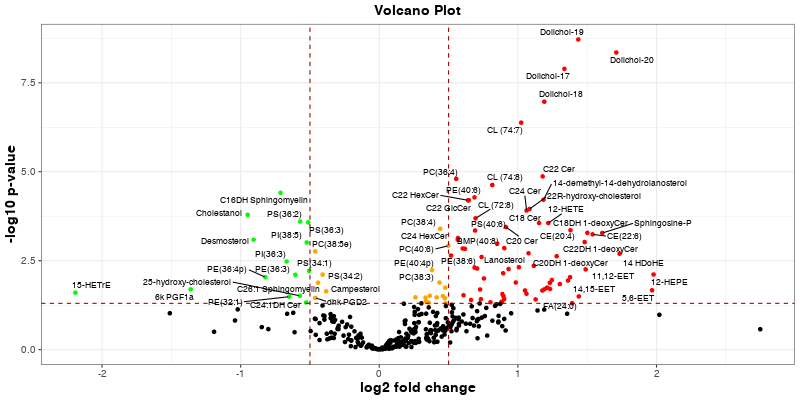

In [27]:
image_png(robjects.r('''
plot_volcano(stats_metabolites, thres_pval= ptreshnum, thres_log2foldchange = thres_log2foldchangenum, TRUE)
'''))

Each color describes a different metabolite group.

### Map metabolite class of the significant metabolites utilzing refmet classification in Metabolomics Workbench
This function not only maps metabolite to metabolite class but also to external databases such as pubchem, inchi key, smiles, and KEGG (if you chose to add in KEGG).

In [28]:
with openrlib.rlock:
    robjects.r('''
    sig_metabolites_kegg_id= map_keggid(sig_metabolites)
    ''')
    pass

#### Check all your significant metabolites have not been assigned metabolite class
Outcome should be 0 elements.

In [29]:
robjects.r('''
setdiff(sig_metabolites$refmet_name, sig_metabolites_kegg_id$refmet_name)
''')

<rpy2.robjects.vectors.StrVector object at 0x7fa627bb6700> [RTYPES.STRSXP]
R classes: ('character',)
[]

### Count the number of metabolites in each of the metabolite classes and plot them with a bar graph

In [30]:
%%appyter hide_code

{% set thres_log2foldchange_countclass = StringField(
    name = 'tres_log2foldchange_countclass',
    label = 'Log2FoldChange Threshhold',
    description= "Float between 0 and 1.",
    default='0.5',
    section='COUNTCLASS'
) %}

In [31]:
%%appyter code_exec

robjects.r.assign('classtype', {{classtype}})

robjects.r('''
metclassvar <- as.character(classtype[1])
count_changes = metcountplot(df_metclass=sig_metabolites_kegg_id, metclass=metclassvar, plotting=TRUE, thres_logfC = 0.5)
''')

```python
robjects.r.assign('classtype', ['sub_class'])
robjects.r('''
metclassvar <- as.character(classtype[1])
count_changes = metcountplot(df_metclass=sig_metabolites_kegg_id, metclass=metclassvar, plotting=TRUE, thres_logfC = 0.5)
''')
```

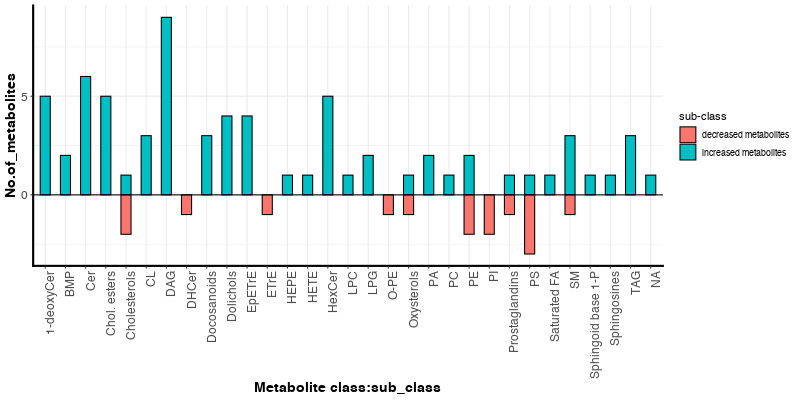

In [32]:
image_png(robjects.r('''
count_changes$plotimg
'''))

### Enrichment class score

Calculate the enrichment score of each metabolite class. 

Enrichment score is calculated through the hypergeometric method.

In [33]:
%%appyter hide_code

{% set sigmets = IntField(
    name = 'sigmets',
    label = 'Minimum # of (most significant) metabolites per class to use in group calculation.',
    description= "We advise to use the number of metabolites in each class as 3 or more. However, if you want to know the enrichment score for all the metabolites, choose 1.",
    default=3,
    section = 'ENRICH'
) %}

In [34]:
%%appyter code_eval
robjects.r.assign('sigmets', {{sigmets}})

```python

robjects.r.assign('sigmets', 3)
```

3


In [35]:
robjects.r('''
metenrichment = metclassenrichment(df_metclass=sig_metabolites_kegg_id,refmet_class, metclass=metclassvar,enrich_stats="HG",no=sigmets)
''')
;

''

## Plot the enrichment score via function plot_met_enrichment

### If no figure shows here, or an error returns, this means no classes had enough significant metabolites. Decrease the significant metabolites per class and rerun the program.

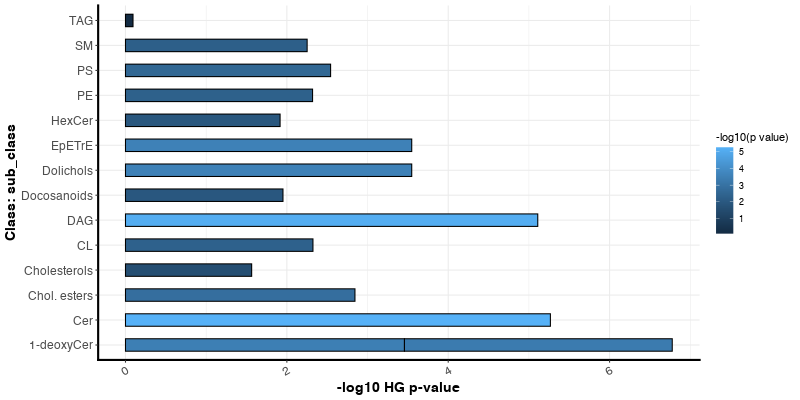

In [36]:
image_png(robjects.r('''
plot_met_enrichment(metenrichment, metclassvar,"HG", no=sigmets)
'''))

### Check the pathways with reactions of all the significant metabolites

In [37]:
%%appyter code_exec

robjects.r.assign('studyOrg', {{studyOrg}})

robjects.r('''
met_path = met_pathways(df_metenrichment = metenrichment, studyOrg)
head(met_path)
''')

```python
robjects.r.assign('studyOrg', 'hsa')
robjects.r('''
met_path = met_pathways(df_metenrichment = metenrichment, studyOrg)
head(met_path)
''')
```

### Get pathway enrichment sore.

Once we have the pathway information, we can calculate enrichment score of pathways using the hypergeometric scores for each pathway.

For hypergeometric score, we need to know the total number of kegg compounds that are linked to kegg pathways. 
N = total no. of cmpds linked to kegg pathway 

L = No. of cmpds in a pathway
M= no. of altered cmpds in a pathway
K =  total no. of altered cmpds
phyper(M,L, N-L, K)


This function also utilizes korg dataset from pathview package.

In [38]:
%%appyter hide_code

{% set keggTF = MultiChoiceField(
    name='keggTF',
    label='Analysis with KEGG',
    description='Would you like the enrichment analysis to occur with all KEGG pathways?',
    default=[
        'FALSE',
    ],
    choices=[
        'TRUE',
        'FALSE'
    ],
    section='ENRICH'
) %}

In [39]:
%%appyter code_exec

robjects.r.assign('keggTF', {{keggTF}})

robjects.r('''
keggTFchar<-as.character(keggTF[1])
''')

```python
robjects.r.assign('keggTF', ['FALSE'])
robjects.r('''
keggTFchar<-as.character(keggTF[1])
''')
```

In [40]:
%%appyter code_exec

korgvar = "{{ url_for('Users/Callie/Documents/199/MetENP/vignettes/static', filename='korg.RData') }}"
ls_pathvar = "{{ url_for('Users/Callie/Documents/199/MetENP/vignettes/static', filename='ls_path.RData') }}"

robjects.r.assign('korgvar', korgvar)
robjects.r.assign('ls_pathvar', ls_pathvar)

```python
korgvar = "/Users/Callie/Documents/199/MetENP/vignettes/static/korg.RData"
ls_pathvar = "/Users/Callie/Documents/199/MetENP/vignettes/static/ls_path.RData"
robjects.r.assign('korgvar', korgvar)
robjects.r.assign('ls_pathvar', ls_pathvar)
```

In [41]:
robjects.r('''
load(korgvar)
load(ls_pathvar)
''')

ls_path


In [42]:
robjects.r('''
kegg_es = path_enrichmentscore(met_path,sig_metabolite_kegg_id=sig_metabolite_kegg_id,ls_path=ls_path,refmet_class=refmet_class,sps=studyOrg,padj=padjchar, kegg_comp_path=keggTFchar)
head(kegg_es)
''')

,,Pathway name,No.of mets in study,Total_no._of_comps_in_pathway,pathway_HG p-value,Padjust
0,1,Arachidonic acid metabolism,4,75,0.999173034565787,0.999173034565787
1,2,Glycerolipid metabolism,12,38,0.008469408188587033,0.02117352047146758
2,3,Glycerophospholipid metabolism,17,56,0.0025773089633421425,0.008591029877807143
3,4,"Glycine, serine and threonine metabolism",4,50,0.9705818848647176,0.999173034565787
4,5,Glycosylphosphatidylinositol (GPI)-anchor biosynthesis,13,19,1.8377122608709652e-07,9.188561304354826e-07
5,6,Inositol phosphate metabolism,9,47,0.3070207366874475,0.4386010524106393


### Plot pathway network
Only plotting significant pathways (pathway with p-value significance).

The pathway network is such that it shows metabolites that are connected to different pathways and same metabolite in different pathway. Color of nodes of metabolites are according to the fold change of metabolites (low expression in green and high in red) and size of pathway nodes (square nodes) are according to the number of branches (meaning no of metabolites). All metabolite are written in blue

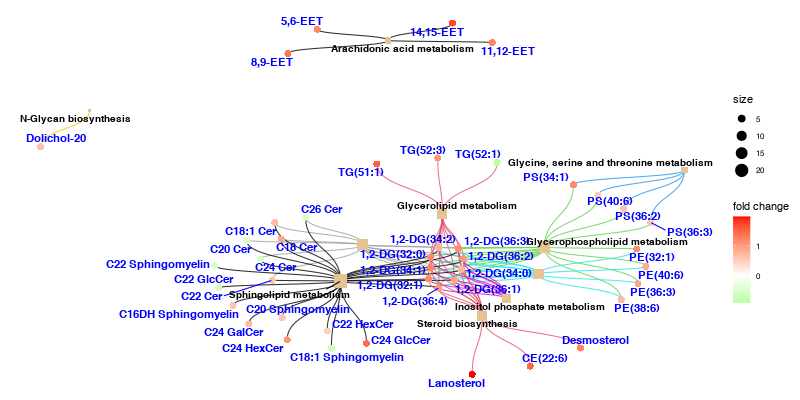

In [43]:
image_png(robjects.r('''
plot_pathway_networks (met_path,kegg_es, TRUE)
'''))

### Heatmap

In [44]:
%%appyter hide_code

{% set x_size_heat = IntField(
    name = 'x_size_heat',
    label = 'Font Size for X',
    description= "To change the size of the heatmap",
    default=8,
    section = 'HEAT'
) %}

In [45]:
%%appyter hide_code

{% set y_size_heat = IntField(
    name = 'y_size_heat',
    label = 'Font Size for Y',
    description= "To change the size of the heatmap",
    default=6,
    section = 'HEAT'
) %}

In [46]:
%%appyter code_exec

robjects.r.assign('x_size_heat', {{x_size_heat}})
robjects.r.assign('y_size_heat', {{y_size_heat}})

```python
robjects.r.assign('x_size_heat', 8)
robjects.r.assign('y_size_heat', 6)
```

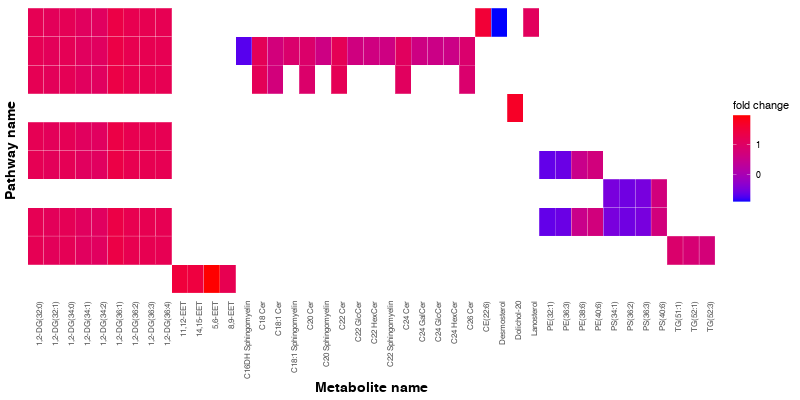

In [47]:
image_png(robjects.r('''
plot_heatmap(met_path, shorten_name=TRUE,refmet_name=FALSE, xaxis=x_size_heat, yaxis=y_size_heat)
'''))

### Dotplot

In [48]:
%%appyter hide_code

{% set x_size_dot = IntField(
    name = 'x_size_dot',
    label = 'Font Size for X',
    description= "To change the size of the dotplot",
    default=8,
    section = 'DOT'
) %}

In [49]:
%%appyter hide_code

{% set y_size_dot = IntField(
    name = 'y_size_dot',
    label = 'Font Size for Y',
    description= "To change the size of the dotplot",
    default=6,
    section = 'DOT'
) %}

In [50]:
%%appyter code_exec

robjects.r.assign('x_size_dot', {{x_size_dot}})
robjects.r.assign('y_size_dot', {{y_size_dot}})

```python
robjects.r.assign('x_size_dot', 8)
robjects.r.assign('y_size_dot', 6)
```

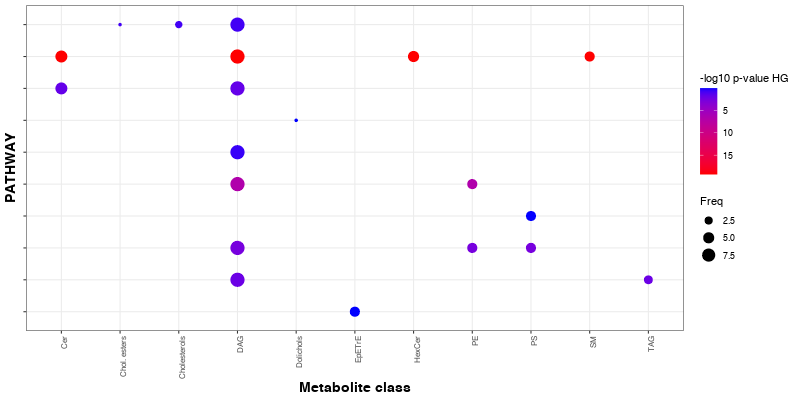

In [51]:
image_png(robjects.r('''
dotplot_met_class_path (met_path, kegg_es, metclassvar,xaxis=x_size_dot,yaxis=y_size_dot)
'''))

### Get the gene and enzyme info

Here we get the information of genes involved in enriched pathways for specified organism

In [52]:
robjects.r('''
met_gene_info = enzyme_gene_info (metenrichment, studyOrg, metclassvar)
head(met_gene_info)
''')

R[write to console]: Error: Names repair functions can't return `NA` values.

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps 

R[write to console]: 2: Use of `count_changes[[metclass]]` is discouraged. Use `.data[[metclass]]` instead. 

R[write to console]: 3: Use of `metclass_stats[[metclass]]` is discouraged. Use `.data[[metclass]]` instead. 

R[write to console]: 4: Use of `metclass_stats[[enrich_stats]]` is discouraged. Use `.data[[enrich_stats]]` instead. 

R[write to console]: 5: Use of `metclass_stats[[enrich_stats]]` is discouraged. Use `.data[[enrich_stats]]` instead. 

R[write to console]: 6: ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps 

R[write to console]: 7: Use of `significant_pathways[["pathway_HG p-value"]]` is discouraged. Use `.data[["pathway_HG p-value"]]` instead. 



RRuntimeError: Error: Names repair functions can't return `NA` values.


#### Get the information if metabolite is a reactant or substrate

In [ ]:
robjects.r('''
rclass_info = react_substrate(met_gene_info)
head(rclass_info)
''')

#### Get gene info in short form

In [ ]:
robjects.r('''
met_gene_info2=data.table::data.table(rclass_info)[,lapply(.SD, function(x) toString(unique(x))), by = 'Metabolite']
''')